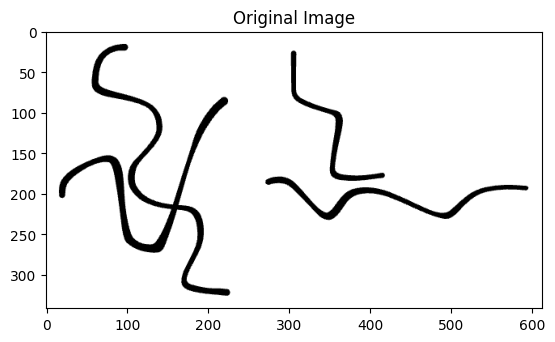

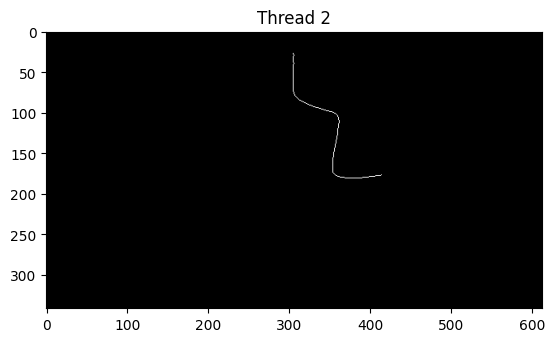

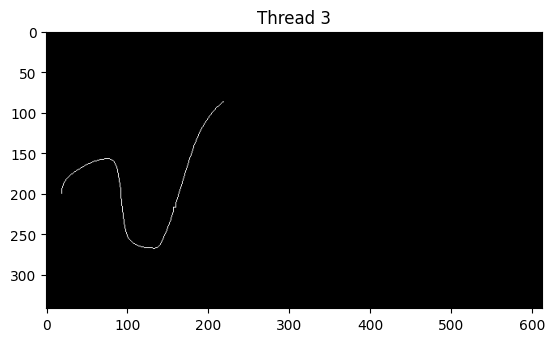

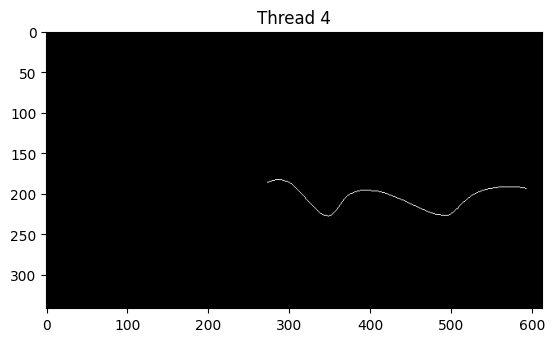

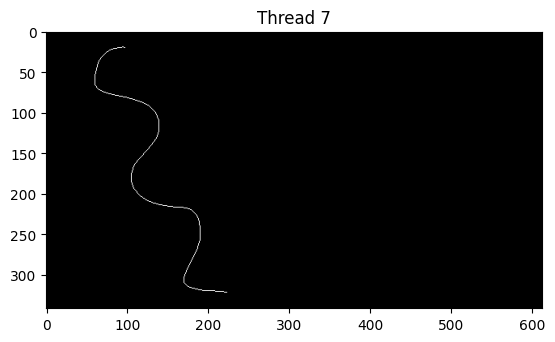

In [12]:
import cv2 as cv
import numpy as np
from skimage import morphology, graph
from skan import Skeleton
import matplotlib.pyplot as plt

def segment_threads(img_path, plot=True):
    # Read the input image
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

    # Display the original image
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.show()

    # Invert the image to get white threads on black background
    img_inverted = 255 - img

    # Threshold the image to binary
    _, img_bin = cv.threshold(img_inverted, 20, 255, cv.THRESH_BINARY)

    # Skeletonize the binary image
    img_skel = morphology.skeletonize(img_bin // 255)

    # Remove small objects (noise)
    img_skel = morphology.remove_small_objects(img_skel.astype(bool), 100, connectivity=2)

    # Convert the skeletonized image to float64, as required by the Skeleton class
    img_skel = img_skel.astype(np.float64)

    # Convert skeleton to a graph
    skel = Skeleton(img_skel)

    # Create a list to store individual thread images
    thread_images = []

    # Define constants for junction handling
    MAX_JUNCTION = 4
    MAX_ANGLE = 80
    DELTA = 3

    # Extract path coordinates
    paths = [list(np.array(skel.path_coordinates(i)).astype(int)) for i in range(skel.n_paths)]
    
    # Get endpoints and their direction vectors
    endpoints = [[p[0], np.subtract(p[0], p[DELTA]), i] for i, p in enumerate(paths)] + \
                [[p[-1], np.subtract(p[-1], p[-1 - DELTA]), i] for i, p in enumerate(paths)]

    # Calculate angles and merge paths
    angles = []
    costs = np.where(img_skel, 1, 255)

    for i1 in range(len(endpoints)):
        for i2 in range(i1 + 1, len(endpoints)):
            e1, d1, p1 = endpoints[i1]
            e2, d2, p2 = endpoints[i2]
            if p1 != p2:
                p, c = graph.route_through_array(costs, e1, e2)
                if c <= MAX_JUNCTION:
                    rad = np.arctan2(d2[0], d2[1]) - np.arctan2(d1[0], d1[1])
                    deg = np.abs((np.rad2deg(rad) % 360) - 180)
                    if deg <= MAX_ANGLE:
                        angles.append((deg, i1, i2, p))

    # Sort by least angle deviation
    angles.sort(key=lambda a: a[0])

    # Merge paths with minimal angle deviation
    for deg, i1, i2, p in angles:
        e1, e2 = endpoints[i1], endpoints[i2]
        if e1 and e2:
            p1, p2 = e1[2], e2[2]
            paths[p1] = paths[p1] + paths[p2] + p
            for i, e in enumerate(endpoints):
                if e and e[2] == p2:
                    endpoints[i][2] = p1
            paths[p2], endpoints[i1], endpoints[i2] = [], [], []

    # Generate images for each segmented thread
    for idx, path in enumerate(paths):
        if path:
            thread_img = np.zeros_like(img, dtype=np.uint8)
            for coord in path:
                thread_img[coord[0], coord[1]] = 255
            thread_images.append(thread_img)

            # Optionally display each thread
            if plot:
                plt.imshow(thread_img, cmap='gray')
                plt.title(f'Thread {idx + 1}')
                plt.show()

    return thread_images

thread_images = segment_threads('04-lines.png')


In [29]:
import os

import cv2 as cv
import numpy as np

from skan import Skeleton
from skimage import graph, morphology
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

MAX_JUNCTION = 10  # maximal size of junctions
MAX_ANGLE = 80  # maximal angle in junction
DELTA = 5  # distance from endpoint to inner point to estimate direction at endpoint
THRESHOLD_VALUE = 30  # threshold value for binarization
MIN_PATH_LENGTH = 30  # minimal length of path to be considered as thread


def angle(v1, v2):
    rad = np.arctan2(v2[0], v2[1]) - np.arctan2(v1[0], v1[1])
    return np.abs((np.rad2deg(rad) % 360) - 180)


def calculate_path_length(path):
    """Calculate the length of a path given its coordinates"""
    length = 0
    for i in range(1, len(path)):
        length += euclidean(path[i - 1], path[i])
    return length


def segment_threads(filename: str):
    """Segment threads and return their lengths"""
    base_name = os.path.splitext(os.path.basename(filename))[0]
    output_folder = f"{base_name}"
    path_folder = os.path.join(output_folder, "paths")
    fiber_folder = os.path.join(output_folder, "fibers")
    os.makedirs(path_folder, exist_ok=True)
    os.makedirs(fiber_folder, exist_ok=True)
    # Load and preprocess image
    img = cv.imread(filename)

    # TODO: If background is white, invert the image
    img = 255 - img
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Dilate and threshold
    kernel = np.ones((2, 2), np.uint8)
    dilated = cv.dilate(gray, kernel, iterations=1)
    _, thresh = cv.threshold(dilated, THRESHOLD_VALUE, 255, cv.THRESH_BINARY)

    # cv.imwrite("hello-owo.png", thresh)

    # Skeletonize
    skeleton = morphology.skeletonize(thresh, method="lee")
    skeleton = morphology.remove_small_objects(
        skeleton.astype(bool), 100, connectivity=2
    )

    # Split skeleton into paths, for each path longer than MAX_JUNCTION get list of point coordinates
    g = Skeleton(skeleton)
    lengths = np.array(g.path_lengths())
    paths = [
        list(np.array(g.path_coordinates(i)).astype(int))
        for i in range(g.n_paths)
        if lengths[i] > MAX_JUNCTION
    ]

    # Get endpoints of path and vector to inner point to estimate direction at endpoint
    endpoints = [
        [p[0], np.subtract(p[0], p[DELTA]), i] for i, p in enumerate(paths)
    ] + [[p[-1], np.subtract(p[-1], p[-1 - DELTA]), i] for i, p in enumerate(paths)]

    # Get each pair of distinct endpoints with the same junction and calculate deviation of angle
    angles = []
    costs = np.where(skeleton, 1, 255)  # cost array for route_through_array

    for i1 in range(len(endpoints)):
        for i2 in range(i1 + 1, len(endpoints)):
            e1, d1, p1 = endpoints[i1]
            e2, d2, p2 = endpoints[i2]
            if p1 != p2:
                p, c = graph.route_through_array(
                    costs, e1, e2
                )  # check connectivity of endpoints at junction
                if c <= MAX_JUNCTION:
                    deg = angle(d1, d2)  # get deviation of directions at junction
                    if deg <= MAX_ANGLE:
                        angles.append((deg, i1, i2, p))

    # Merge paths, with least deviation of angle first
    angles.sort(key=lambda a: a[0])

    for deg, i1, i2, p in angles:
        e1, e2 = endpoints[i1], endpoints[i2]
        if e1 and e2:
            p1, p2 = e1[2], e2[2]
            paths[p1] = (
                paths[p1] + paths[p2] + p
            )  # merge path 2 into path 1, add junction from route_through_array
            for i, e in enumerate(
                endpoints
            ):  # switch path 2 at other endpoint to new merged path 1
                if e and e[2] == p2:
                    endpoints[i][2] = p1
            paths[p2], endpoints[i1], endpoints[i2] = (
                [],
                [],
                [],
            )  # disable merged path and endpoints

    filtered_paths = [p for p in paths if len(p) > MIN_PATH_LENGTH]
    
    for idx, p in enumerate(filtered_paths):
        if p:
            img1 = img.copy()
            thickness = 2  # Set the desired thickness (this is the radius of neighboring pixels to color)
            
            for v in p:
                for dx in range(-thickness, thickness + 1):
                    for dy in range(-thickness, thickness + 1):
                        x, y = v[0] + dx, v[1] + dy
                        if 0 <= x < img1.shape[0] and 0 <= y < img1.shape[1]:
                            img1[x, y] = [0, 0, 255]  # Set pixel to red
            
            cv.imwrite(os.path.join(fiber_folder, f'fiber-{idx}.png'), img1)

    path_lengths = [calculate_path_length(path) for path in filtered_paths]

    return [filename, path_lengths]

In [29]:
segment_threads('04-lines.png')

['04-lines.png',
 [251.6396103067894, 594.9177596098864, 382.5756851698609, 847.6359360308893]]

In [34]:
segment_threads('08-lines.png')

['08-lines.png',
 [1261.9815585542008,
  529.2735644059644,
  440.12809899320024,
  609.2809447463846,
  1077.3991019482855]]

In [33]:
import os

import cv2 as cv
import numpy as np

from skan import Skeleton
from skimage import graph, morphology
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

MAX_JUNCTION = 10  # maximal size of junctions
MAX_ANGLE = 80  # maximal angle in junction
DELTA = 5  # distance from endpoint to inner point to estimate direction at endpoint
MIN_PATH_LENGTH = 30  # minimal length of path to be considered as thread
BRIGHTNESS_THRESHOLD = 128 # minimal mean intensity of a binarized image to consider a 'white' background and a 'black' foreground

def angle(v1, v2):
    rad = np.arctan2(v2[0], v2[1]) - np.arctan2(v1[0], v1[1])
    return np.abs((np.rad2deg(rad) % 360) - 180)


def calculate_path_length(path):
    """Calculate the length of a path given its coordinates"""
    length = 0
    for i in range(1, len(path)):
        length += euclidean(path[i - 1], path[i])
    return length


def segment_threads(filename: str):
    """Segment threads and return their lengths"""
    base_name = os.path.splitext(os.path.basename(filename))[0]
    output_folder = f"{base_name}"
    path_folder = os.path.join(output_folder, "paths")
    fiber_folder = os.path.join(output_folder, "fibers")
    os.makedirs(path_folder, exist_ok=True)
    os.makedirs(fiber_folder, exist_ok=True)
    # Load and preprocess image
    img = cv.imread(filename)
    
    # Convert the image into grayscale
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Invert the grayscale image if needed
    _, otsu_thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    if np.mean(otsu_thresh) >= BRIGHTNESS_THRESHOLD:
        gray = 255 - gray

    # Dilate and threshold
    kernel = np.ones((2, 2), np.uint8)
    dilated = cv.dilate(gray, kernel, iterations=1)
    _, thresh = cv.threshold(dilated, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # Skeletonize
    skeleton = morphology.skeletonize(thresh, method="lee")
    skeleton = morphology.remove_small_objects(
        skeleton.astype(bool), 100, connectivity=2
    )

    # Split skeleton into paths, for each path longer than MAX_JUNCTION get list of point coordinates
    g = Skeleton(skeleton)
    lengths = np.array(g.path_lengths())
    paths = [
        list(np.array(g.path_coordinates(i)).astype(int))
        for i in range(g.n_paths)
        if lengths[i] > MAX_JUNCTION
    ]

    # Get endpoints of path and vector to inner point to estimate direction at endpoint
    endpoints = [
        [p[0], np.subtract(p[0], p[DELTA]), i] for i, p in enumerate(paths)
    ] + [[p[-1], np.subtract(p[-1], p[-1 - DELTA]), i] for i, p in enumerate(paths)]

    # Get each pair of distinct endpoints with the same junction and calculate deviation of angle
    angles = []
    costs = np.where(skeleton, 1, 255)  # cost array for route_through_array

    for i1 in range(len(endpoints)):
        for i2 in range(i1 + 1, len(endpoints)):
            e1, d1, p1 = endpoints[i1]
            e2, d2, p2 = endpoints[i2]
            if p1 != p2:
                p, c = graph.route_through_array(
                    costs, e1, e2
                )  # check connectivity of endpoints at junction
                if c <= MAX_JUNCTION:
                    deg = angle(d1, d2)  # get deviation of directions at junction
                    if deg <= MAX_ANGLE:
                        angles.append((deg, i1, i2, p))

    # Merge paths, with least deviation of angle first
    angles.sort(key=lambda a: a[0])

    for deg, i1, i2, p in angles:
        e1, e2 = endpoints[i1], endpoints[i2]
        if e1 and e2:
            p1, p2 = e1[2], e2[2]
            paths[p1] = (
                paths[p1] + paths[p2] + p
            )  # merge path 2 into path 1, add junction from route_through_array
            for i, e in enumerate(
                endpoints
            ):  # switch path 2 at other endpoint to new merged path 1
                if e and e[2] == p2:
                    endpoints[i][2] = p1
            paths[p2], endpoints[i1], endpoints[i2] = (
                [],
                [],
                [],
            )  # disable merged path and endpoints

    filtered_paths = [p for p in paths if len(p) > MIN_PATH_LENGTH]
    
    for idx, p in enumerate(filtered_paths):
        if p:
            img1 = img.copy()
            thickness = 2  # Set the desired thickness (this is the radius of neighboring pixels to color)
            
            for v in p:
                for dx in range(-thickness, thickness + 1):
                    for dy in range(-thickness, thickness + 1):
                        x, y = v[0] + dx, v[1] + dy
                        if 0 <= x < img1.shape[0] and 0 <= y < img1.shape[1]:
                            img1[x, y] = [0, 0, 255]  # Set pixel to red
            
            cv.imwrite(os.path.join(fiber_folder, f'fiber-{idx}.png'), img1)

    path_lengths = [calculate_path_length(path) for path in filtered_paths]

    return [filename, path_lengths]

In [25]:
segment_threads('image-1.png')

['image-1.png',
 [1006.6257176153943,
  1596.0429186487388,
  1156.2587096544785,
  1220.0459532945006]]

In [26]:
segment_threads('image-2.jpg')

['image-2.jpg',
 [1128.2731406397577,
  1301.335639798208,
  1011.9195234117669,
  989.2504472809658,
  1845.5394306489593]]

In [27]:
segment_threads('image-3.png')

['image-3.png',
 [643.3346854008246,
  614.1881985005207,
  430.0754669667828,
  1481.9099968222113,
  715.1918064315751,
  853.6757176540721]]